In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, glob
import pp, pf
import cna
plt.style.use('../pp.mplstyle')

In [2]:
d = cna.read('/data/srlab1/laurie-yakir/tbru.real/2.munged/harmcca20.h5ad')

In [3]:
# parameters
dset = 'harmcca20'
noises = [1,
    1.11,
    1.25,
    1.43,
    1.67,
    2, 
    2.5,
    3.33,
    5,
    10,
    99,
]
snr = 1/np.array(noises)

methods = [
    'CNAfast',
    'MASC_leiden0p2',
    'MASC_leiden1',
    'MASC_leiden2',
    'MASC_leiden5',
]
MASCs = methods[1:]

In [4]:
def read(simname):
    df = pd.DataFrame()

    for n in noises:
        folder = pf.simresults(dset, simname.format(n))
        for m in methods:
            rs = [
                    pickle.load(open(f, 'rb'))
                    for f in glob.glob('{}/{}/*.p'.format(folder, m))
                ]
            rs = pd.DataFrame({
                'id':[r.id for r in rs],
                'p':[r.p for r in rs],
                'interp':[r.interp for r in rs],
                'pheno':[r.pheno for r in rs],
                'noise':[n for r in rs],
                'method':[m for r in rs]
            })
            df = df.append(rs, ignore_index=True)
    return df

def aggregate(df):
    # aggregate
    results = dict()
    for n in noises:
        results[n] = df[df.noise == n][['id','method','p','interp']].pivot(index='id', columns='method')

        # add best-of-MASC results
        results[n]['p','MASC_best'] = results[n]['p'][MASCs].min(axis=1, skipna=False)*len(MASCs)
        results[n]['interp','MASC_best'] = results[n]['interp'][MASCs].mean(axis=1, skipna=False)
        results[n] = results[n][np.isfinite(results[n].p.MASC_best)]
    return results

def calculate(results):
    # calculate power and interpretability w std errors
    allmethods = methods+['MASC_best']
    power = pd.DataFrame(index=allmethods, columns=pd.MultiIndex.from_product([['avg', 'se'], noises]))
    for n in noises:
        power['avg', n] = (results[n].p[allmethods] <= 0.05).mean(axis=0)
        power['se', n] = (results[n].p[allmethods] <= 0.05).std(axis=0) / np.sqrt(len(results[n]))

    interp = pd.DataFrame(index=allmethods, columns=pd.MultiIndex.from_product([['avg', 'se'], noises]))
    for n in noises:
        interp['avg', n] = results[n].interp[allmethods].mean(axis=0)
        interp['se', n] = results[n].interp[allmethods].std(axis=0) / np.sqrt(len(results[n]))
        
    return power, interp

In [30]:
def umap(z, mask, ax, ix=None):
    if ix is None: ix = np.repeat([True], len(z))
    z = z[ix][mask[ix]]
    if z.std() > 0:
        z -= z.min()
        z /= z.max()
    else:
        z[:] = 1
    ax.scatter(*d.obsm['X_umap'][ix,:2].T, s=2, color='gray', edgecolors='none', alpha=0.05,
               rasterized=True)
    ax.scatter(*d.obsm['X_umap'][ix,:2][mask[ix]].T, s=2, c=z, edgecolors='none', alpha=0.05, cmap='seismic', vmin=-1, vmax=1,
               rasterized=True)
    ax.axis('off')

def powerplot(power, ax, methodinfo, legend=False, ylabels=False):
    for m,l,c in methodinfo:
        ax.plot(snr, power.loc[m].avg, color=c, label=l, marker='.', ms=1, linewidth = 0.5)
        ax.fill_between(snr, power.loc[m].avg - power.loc[m].se, power.loc[m].avg + power.loc[m].se, 
                        color=c, alpha=0.4, lw=0) 
    ax.set_xlim(0, 1) 
    ax.set_xticks([])
    ax.set_ylim(0,1.1)
    if ylabels:
        ax.set_yticks([0,1]); ax.set_yticklabels(['0.0', '1.0'])
        ax.set_ylabel('Power')
    else:
        ax.set_yticks([])
    if legend: ax.legend(loc=4)

def interpplot(interp, ax, methodinfo, legend=False, xlabel=False, ylabels=False, ymin=0):
    for m,l,c in methodinfo:
        ax.plot(snr, interp.loc[m].avg, color=c, label=l, marker='.', ms=1, linewidth = 0.5)
        ax.fill_between(snr, interp.loc[m].avg - interp.loc[m].se, interp.loc[m].avg + interp.loc[m].se, 
                        color=c, alpha=0.4, lw=0)
    ax.set_xlim(0, 1)
    ax.set_xticks([0,1])
    if xlabel:
        ax.set_xlabel('Signal-to-Noise Ratio')
        
    ax.set_ylim(ymin,0.55)
    if ylabels:
        ax.set_yticks([0,0.5])
        ax.set_ylabel('Interpretability')
    else:
        ax.set_yticks([])
    if legend: ax.legend(loc=4)

## Main power/interpretability figure

In [31]:
# choose example phenotypes to visualize in figure
clust = 5
mask = d.obs.leiden2==str(clust)

# causalclust
z_causalclust = np.zeros(len(d))
z_causalclust[mask] = 1

# GEpc
z_geneexpPCs = d.X[:,0]

# Make cluster_specific PC1 example
import scanpy as sc
z_clusterspecificPC1 = np.zeros(len(d))
z_clusterspecificPC1[mask]=sc.pp.pca(data=d.X[mask,:], n_comps=2)[:,0]

clusterabundance/noise_{}/causalclust_leiden2
geneexpPCs/noise_{}
clusterspecificPC1/noise_{}/causalclust_leiden1


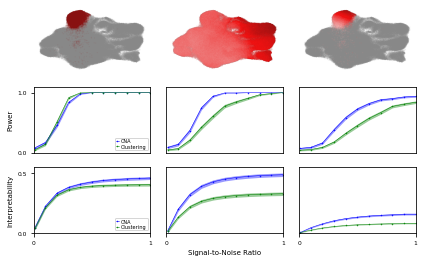

In [33]:
fig, axs = plt.subplots(3,3, figsize=(6,3.75))
methodinfo = [('CNAfast', 'CNA', 'blue'), ('MASC_best', 'Clustering', 'green')]

for i, (simname, z, mask) in enumerate([
    ('clusterabundance/noise_{}/causalclust_leiden2', z_causalclust, mask),
    ('geneexpPCs/noise_{}', z_geneexpPCs, np.ones(len(d)).astype(bool)),
    ('clusterspecificPC1/noise_{}/causalclust_leiden1', z_clusterspecificPC1, mask),
    ]):
    print(simname)
    umap(z, mask, axs[0,i])
    df = read(simname)
    results = aggregate(df)
    power, interp = calculate(results)
    powerplot(power, axs[1,i], methodinfo,
            ylabels=i==0, legend=i==0)
    interpplot(interp, axs[2, i], methodinfo,
            xlabel=i==1, ylabels=i==0, legend=i==0)
plt.tight_layout()
plt.savefig('../_figs/rawmainfig.sim.power_interp.pdf', dpi=2000)

## Supplementary power/interpretability figure

clusterabundance/noise_{}/causalclust_leiden2
geneexpPCs/noise_{}
clusterspecificPC1/noise_{}/causalclust_leiden1


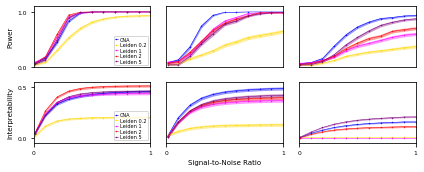

In [21]:
fig, axs = plt.subplots(2,3, figsize=(6,2/3*3.75))
methodinfo = [('CNAfast', 'CNA', 'blue'), 
              ('MASC_leiden0p2', 'Leiden 0.2', 'gold'), ('MASC_leiden1', 'Leiden 1', 'fuchsia'),
              ('MASC_leiden2', 'Leiden 2', 'red'), ('MASC_leiden5', 'Leiden 5', 'purple')]

for i, simname in enumerate([
    'clusterabundance/noise_{}/causalclust_leiden2',
    'geneexpPCs/noise_{}',
    'clusterspecificPC1/noise_{}/causalclust_leiden1',
    ]):
    print(simname)
    df = read(simname)
    results = aggregate(df)
    power, interp = calculate(results)
    powerplot(power, axs[0,i], methodinfo,
                    ylabels=i==0, legend=i==0)
    interpplot(interp, axs[1, i], methodinfo,
                    xlabel=i==1, ylabels=i==0, legend=i==0, ymin=-0.05)
plt.tight_layout()
plt.savefig('../_figs/suppfig.sim.power_interp.pdf', dpi=1000)